# Maximum A-Posteriori (MAP) for parameters of univariate and multivariate normal distribution in PyTorch

In [1]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
dist = torch.distributions

#### Creating a 1d normal distribution

In [3]:
uv_normal = dist.Normal(loc=0.0, scale=1.0)

#### Sampling from the distribution

In [28]:
samples = uv_normal.sample(sample_shape=[100])

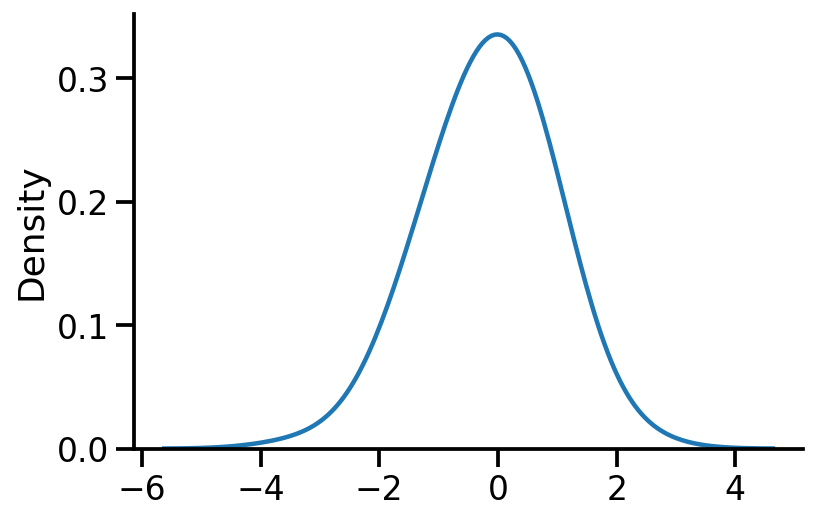

In [29]:
sns.kdeplot(samples, bw_adjust=2)
sns.despine()

#### Defining the prior

In [87]:
prior_mu = torch.tensor(5.0, requires_grad=True)
prior = dist.Normal(loc=prior_mu, scale=1.0)
prior

Normal(loc: 5.0, scale: 1.0)

#### Computing logprob of prior for a mu

In [88]:
def logprob_prior(mu):
    return -prior.log_prob(mu)

#### Computing logprob of observing data given a mu

In [89]:
stdev_likelihood = 1.0


def log_likelihood(mu, samples):

    to_learn = torch.distributions.Normal(loc=mu, scale=stdev_likelihood)
    return -torch.sum(to_learn.log_prob(samples))

In [90]:
mu = torch.tensor(-2.0, requires_grad=True)

log_likelihood(mu, samples), logprob_prior(mu)
log_likelihood(mu, samples).item()

305.98101806640625

In [91]:
out = {"Logprob_Prior": {}, "LogLikelihood": {}}
for mu_s in torch.linspace(-10, 10, 100):
    t = mu_s.item()
    mu = torch.tensor(mu_s)
    out["Logprob_Prior"][t] = logprob_prior(mu).item()
    out["LogLikelihood"][t] = log_likelihood(mu, samples).item()

/var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/ipykernel_73152/3102909564.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mu_s)


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

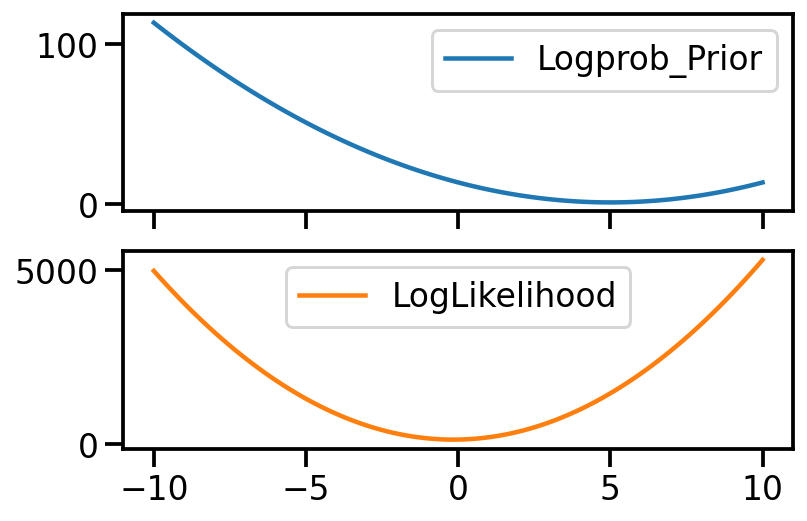

In [92]:
pd.DataFrame(out).plot(subplots=True)

In [103]:
def loss(mu):
    return log_likelihood(mu, samples) + logprob_prior(mu)


mu = torch.tensor(2.0, requires_grad=True)

opt = torch.optim.Adam([mu], lr=0.01)
for i in range(1500):
    loss_val = loss(mu)
    loss_val.backward()
    if i % 100 == 0:
        print(f"Iteration: {i}, Loss: {loss_val.item():0.2f}, Loc: {mu.item():0.6f}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 374.37, Loc: 2.000000
Iteration: 100, Loss: 222.93, Loc: 1.092788
Iteration: 200, Loss: 166.98, Loc: 0.468122
Iteration: 300, Loss: 152.88, Loc: 0.119012
Iteration: 400, Loss: 150.57, Loc: -0.034995
Iteration: 500, Loss: 150.33, Loc: -0.088207
Iteration: 600, Loss: 150.31, Loc: -0.102667
Iteration: 700, Loss: 150.31, Loc: -0.105761
Iteration: 800, Loss: 150.31, Loc: -0.106279
Iteration: 900, Loss: 150.31, Loc: -0.106346
Iteration: 1000, Loss: 150.31, Loc: -0.106352
Iteration: 1100, Loss: 150.31, Loc: -0.106353
Iteration: 1200, Loss: 150.31, Loc: -0.106353
Iteration: 1300, Loss: 150.31, Loc: -0.106353
Iteration: 1400, Loss: 150.31, Loc: -0.106353


#### Analytical MAP estimate of location

$\hat{\theta}_{MAP}=\dfrac{n}{n+\sigma^{2}} \bar{x}+\dfrac{\sigma^{2}}{n+\sigma^{2}} \mu$

In [94]:
prior_mu

tensor(5., requires_grad=True)

In [106]:
n = samples.shape[0]
sample_mean = samples.mean()
n_plus_variance = n + stdev_likelihood**2

loc_map = ((n * sample_mean) / n_plus_variance) + (
    (stdev_likelihood**2) / (n_plus_variance)
) * prior_mu
loc_map.item()

-0.1063527911901474

In [107]:
torch.allclose(loc_map, mu)

True

##### Setting 2: Learning location and scale

An important difference from the previous code is that we need to use a transformed variable to ensure scale is positive. We do so by using `softplus`.

In [112]:
mu = torch.tensor(1.0, requires_grad=True)
scale = torch.tensor(2.0, requires_grad=True)


def log_likelihood(mu, scale, samples):
    scale_softplus = torch.functional.F.softplus(scale)
    to_learn = torch.distributions.Normal(loc=mu, scale=scale_softplus)
    return -torch.sum(to_learn.log_prob(samples))


def loss(mu, scale):
    return log_likelihood(mu, scale, samples) + logprob_prior(mu)


opt = torch.optim.Adam([mu, scale], lr=0.01)
for i in range(1500):
    loss_val = loss(mu, scale)
    loss_val.backward()
    if i % 100 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}, Loc: {mu.item():0.3f}, Scale: {torch.functional.F.softplus(scale).item():0.3f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 200.89, Loc: 1.000, Scale: 2.127
Iteration: 100, Loss: 158.51, Loc: 0.086, Scale: 1.282
Iteration: 200, Loss: 149.98, Loc: -0.112, Scale: 0.942
Iteration: 300, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 400, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 500, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 600, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 700, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 800, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 900, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 1000, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 1100, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 1200, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 1300, Loss: 149.98, Loc: -0.112, Scale: 0.943
Iteration: 1400, Loss: 149.98, Loc: -0.112, Scale: 0.943


We can see that our gradient based methods parameters match those of the MLE computed analytically.

In [114]:
mvn = dist.MultivariateNormal(
    loc=torch.tensor([1.0, 1.0]),
    covariance_matrix=torch.tensor([[2.0, 0.5], [0.5, 0.4]]),
)

In [118]:
mle_mvn_loc = mvn_samples = mvn.sample([1000])

In [121]:
loss

In [130]:
loc = torch.tensor([-1.0, 1.0], requires_grad=True)
tril = torch.autograd.Variable(torch.tril(torch.ones(2, 2)), requires_grad=True)
opt = torch.optim.Adam([loc, tril], lr=0.01)

prior = dist.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]),
    covariance_matrix=torch.tensor([[1.0, 0.0], [0.0, 1.0]])
)


def log_likelihood(loc, tril, samples):
    cov = tril @ tril.t()
    to_learn = torch.distributions.MultivariateNormal(loc=loc, covariance_matrix=cov)
    return -torch.sum(to_learn.log_prob(samples))


def logprob_prior(loc):
    return -prior.log_prob(loc)


def loss(loc, tril, samples):
    return log_likelihood(loc, tril, samples) + logprob_prior(loc)

In [131]:
for i in range(8100):
    to_learn = dist.MultivariateNormal(loc=loc, covariance_matrix=tril @ tril.t())
    loss_value = loss(loc, tril, mvn_samples)
    loss_value.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss_value.item():0.2f}, Loc: {loc}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 7663.86, Loc: tensor([-1.,  1.], requires_grad=True)
Iteration: 500, Loss: 2540.96, Loc: tensor([0.8229, 0.9577], requires_grad=True)
Iteration: 1000, Loss: 2526.40, Loc: tensor([1.0300, 1.0076], requires_grad=True)
Iteration: 1500, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 2000, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 2500, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 3000, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 3500, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 4000, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 4500, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 5000, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 5500, Loss: 2526.40, Loc: tensor([1.0308, 1.0077], requires_grad=True)
Iteration: 6000, Loss: 252

In [136]:
tril@tril.t(),mvn.covariance_matrix, prior.covariance_matrix

(tensor([[1.9699, 0.4505],
         [0.4505, 0.3737]], grad_fn=<MmBackward0>),
 tensor([[2.0000, 0.5000],
         [0.5000, 0.4000]]),
 tensor([[1., 0.],
         [0., 1.]]))

In [ ]:
Todo

1. Expand on MVN case
2. Clean up code
3. Visualize, prior, likelihood, MLE, MAP 
4. Shrinkage estimation (reference Murphy book)
5. Inverse Wishart distribution

References

1. https://stats.stackexchange.com/questions/351549/maximum-likelihood-estimators-multivariate-gaussian
2. https://forum.pyro.ai/t/mle-for-normal-distribution-parameters/3861/3
3. https://ericmjl.github.io/notes/stats-ml/estimating-a-multivariate-gaussians-parameters-by-gradient-descent/
4. https://www.youtube.com/watch?v=KogqeZ_88-g&list=PLD0F06AA0D2E8FFBA&index=32